In [47]:
!pip install pandas sqlalchemy matplotlib numpy


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine

# Database connection details
db_username = 'postgres'
db_password = 'Brainstorm99&&'
db_host = '127.0.0.1'
db_port = '5432'
db_name = 'Instacart_Analytics'

# Create a connection to the PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}')


In [99]:
# Load data from tables into Pandas DataFrames
orders_df = pd.read_sql("SELECT * FROM public.orders", con=engine)
order_products_prior_df = pd.read_sql("SELECT * FROM public.order_products__prior", con=engine)
products_df = pd.read_sql("SELECT * FROM public.products", con=engine)
departments_df = pd.read_sql("SELECT * FROM public.departments", con=engine)

In [100]:
# Merge order_products_prior with orders to get order hour of day
merged_df = order_products_prior_df.merge(orders_df[['order_id', 'order_hour_of_day']], on='order_id')

# Merge with products to get product names and departments
merged_df = merged_df.merge(products_df[['product_id', 'product_name', 'department_id']], on='product_id')

# Merge with departments to get department names
merged_df = merged_df.merge(departments_df, on='department_id')

# Filter for only the produce department
produce_df = merged_df[merged_df['department'] == 'produce']

    order_id  product_id  add_to_cart_order  reordered  order_hour_of_day  \
1          2       28985                  2          1                  9   
5          2       17794                  6          1                  9   
8          2       43668                  9          0                  9   
11         3       17704                  3          1                 17   
12         3       21903                  4          1                 17   

               product_name  department_id department  
1     Michigan Organic Kale              4    produce  
5                   Carrots              4    produce  
8   Classic Blend Cole Slaw              4    produce  
11                   Lemons              4    produce  
12     Organic Baby Spinach              4    produce  


In [101]:
# Calculate the total number of orders for each hour
hourly_totals = produce_df.groupby('order_hour_of_day').size().reset_index(name='total_orders')

# Calculate the number of orders for each product at each hour
hourly_product_orders = produce_df.groupby(['order_hour_of_day', 'product_name']).size().reset_index(name='product_orders')

# Merge the totals and product orders
hourly_product_orders = hourly_product_orders.merge(hourly_totals, on='order_hour_of_day')

# Calculate the percentage of orders for each product
hourly_product_orders['percent_orders'] = (hourly_product_orders['product_orders'] / hourly_product_orders['total_orders']) * 100

# Select top N products for visualization
top_products = produce_df['product_name'].value_counts().head(30).index
filtered_df = hourly_product_orders[hourly_product_orders['product_name'].isin(top_products)]


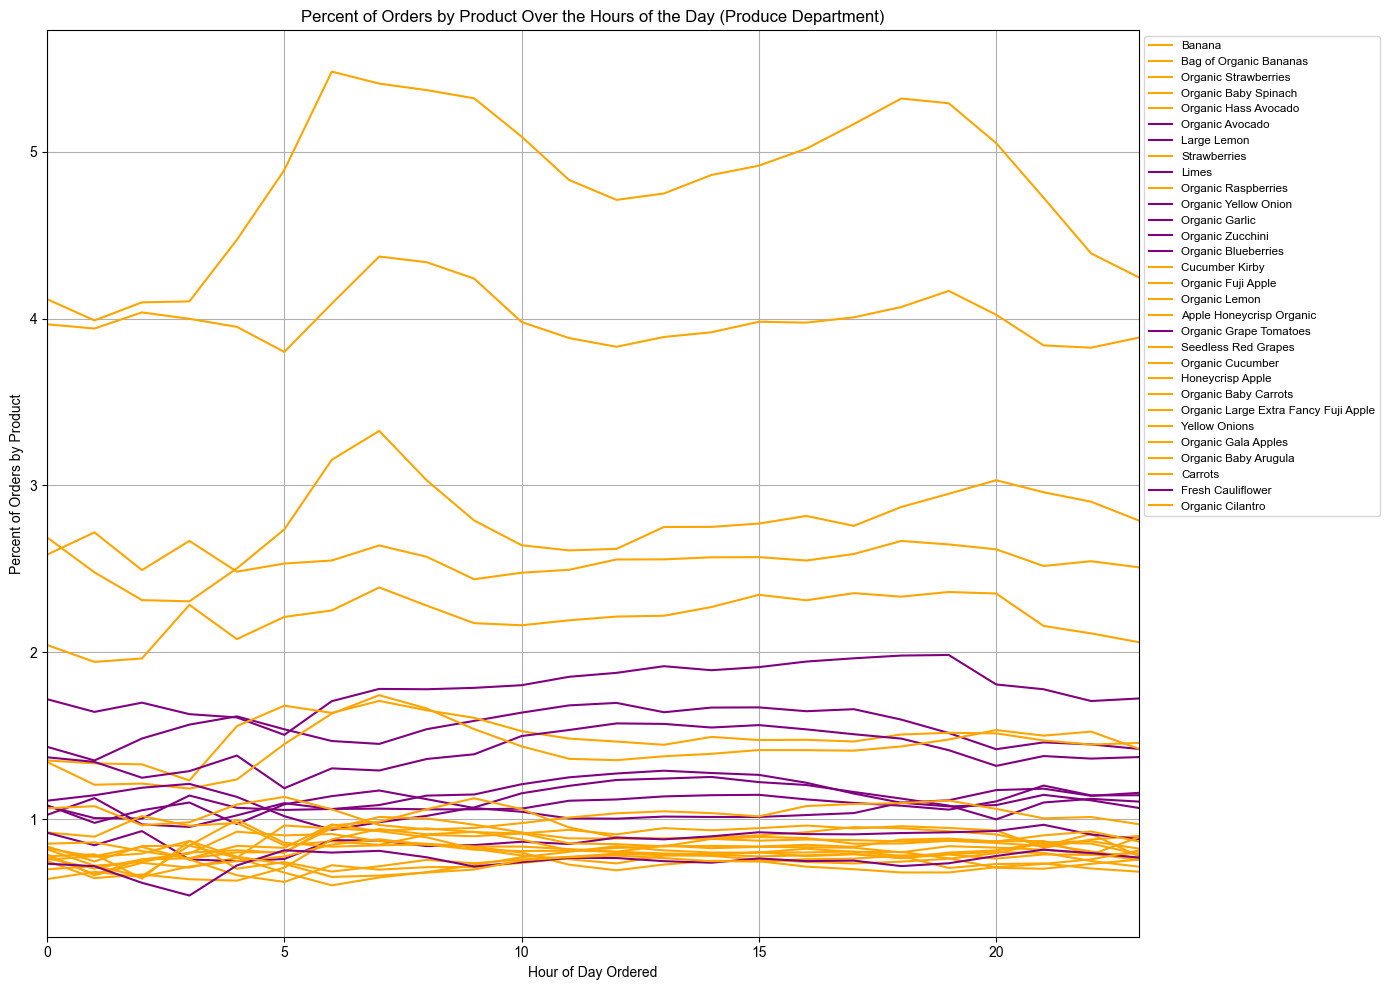

In [102]:
# Find the peak hour of sales for each product
peak_hour = filtered_df.loc[filtered_df.groupby('product_name')['percent_orders'].idxmax()]

# Classify products based on peak hour (12 PM threshold)
peak_hour['classification'] = np.where(peak_hour['order_hour_of_day'] < 12, 'early', 'late')

# Merge the classification back with the filtered_df
filtered_df = filtered_df.merge(peak_hour[['product_name', 'classification']], on='product_name')

# Create line plot
plt.figure(figsize=(14, 10))

# Plot each product's order percentage by hour
for product in top_products:
    product_data = filtered_df[filtered_df['product_name'] == product]
    if product_data['classification'].iloc[0] == 'early':
        plt.plot(product_data['order_hour_of_day'], product_data['percent_orders'], label=product, color='orange')
    else:
        plt.plot(product_data['order_hour_of_day'], product_data['percent_orders'], label=product, color='purple')

# Add labels and title
plt.xlabel('Hour of Day Ordered')
plt.ylabel('Percent of Orders by Product')
plt.title('Percent of Orders by Product Over the Hours of the Day (Produce Department)')
plt.xlim(0, 23)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='small')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [79]:
# Merge order_products_prior with orders to get order hour of day
merged_df = order_products_prior_df.merge(orders_df[['order_id', 'order_hour_of_day']], on='order_id')

# Merge with products to get product names and departments
merged_df = merged_df.merge(products_df[['product_id', 'product_name', 'department_id']], on='product_id')

# Merge with departments to get department names
merged_df = merged_df.merge(departments_df, on='department_id')

# Filter for only the frozen department
frozen_df = merged_df[merged_df['department'] == 'frozen']

# Display the first few rows to ensure the filter is correct
print(frozen_df.head())


     order_id  product_id  add_to_cart_order  reordered  order_hour_of_day  \
60          7       46802                  2          0                 14   
92         11       30162                  1          1                 19   
106        12       38050                 10          1                  8   
110        12       29471                 14          0                  8   
127        14         162                  3          1                 15   

                                      product_name  department_id department  
60                                Pineapple Chunks              1     frozen  
92          Teriyaki & Pineapple Chicken Meatballs              1     frozen  
106  All Natural Boneless Skinless Chicken Breasts              1     frozen  
110                        Combination Pizza Rolls              1     frozen  
127                 Organic Mini Homestyle Waffles              1     frozen  


In [80]:
# Calculate the total number of orders for each hour
hourly_totals = frozen_df.groupby('order_hour_of_day').size().reset_index(name='total_orders')

# Calculate the number of orders for each product at each hour
hourly_product_orders = frozen_df.groupby(['order_hour_of_day', 'product_name']).size().reset_index(name='product_orders')

# Merge the totals and product orders
hourly_product_orders = hourly_product_orders.merge(hourly_totals, on='order_hour_of_day')

# Calculate the percentage of orders for each product
hourly_product_orders['percent_orders'] = (hourly_product_orders['product_orders'] / hourly_product_orders['total_orders']) * 100

# Select top N products for visualization
top_products = frozen_df['product_name'].value_counts().head(30).index
filtered_df = hourly_product_orders[hourly_product_orders['product_name'].isin(top_products)]

# Debug: Display the filtered DataFrame
print(filtered_df.head(40))


      order_hour_of_day                                product_name  \
14                    0  Air Chilled Breaded Chicken Breast Nuggets   
113                   0                                Berry Medley   
141                   0                                 Blueberries   
302                   0           Chicken & Maple Breakfast Sausage   
400                   0                         Chocolate Ice Cream   
427                   0                             Chopped Spinach   
679                   0                      Eggo Homestyle Waffles   
777                   0                     Frozen Broccoli Florets   
804                   0             Frozen Organic Wild Blueberries   
911                   0               Gluten Free Whole Grain Bread   
949                   0                                  Green Peas   
1162                  0                           Macaroni & Cheese   
1173                  0                                Mango Chunks   
1303  

     order_hour_of_day                                product_name  \
180                  6  Air Chilled Breaded Chicken Breast Nuggets   
661                 22                                Berry Medley   
212                  7                                 Blueberries   
213                  7           Chicken & Maple Breakfast Sausage   
604                 20                         Chocolate Ice Cream   
665                 22                             Chopped Spinach   
186                  6                      Eggo Homestyle Waffles   
127                  4                     Frozen Broccoli Florets   
668                 22             Frozen Organic Wild Blueberries   
219                  7               Gluten Free Whole Grain Bread   
670                 22                                  Green Peas   
131                  4                           Macaroni & Cheese   
162                  5                                Mango Chunks   
223                 

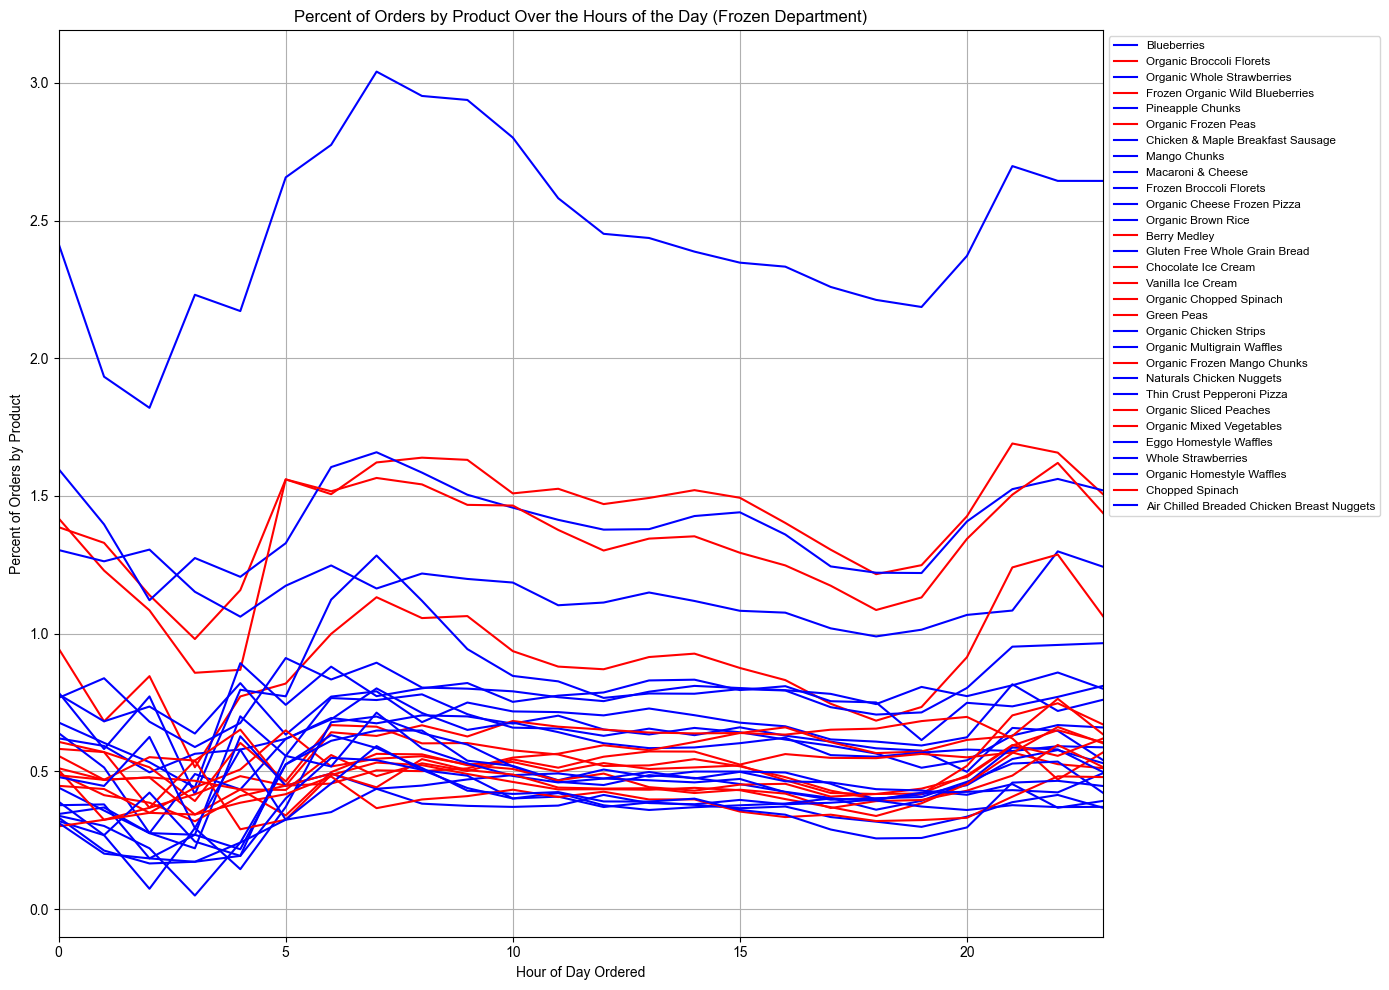

In [96]:
# Find the peak hour of sales for each product
peak_hour = filtered_df.loc[filtered_df.groupby('product_name')['percent_orders'].idxmax()]

# Classify products based on peak hour (12 PM threshold)
peak_hour['classification'] = np.where(peak_hour['order_hour_of_day'] < 12, 'early', 'late')

# Merge the classification back with the filtered_df
filtered_df = filtered_df.merge(peak_hour[['product_name', 'classification']], on='product_name')

# Debug: Display the classification
print(peak_hour.head(40))

# Create line plot
plt.figure(figsize=(14, 10))

# Plot each product's order percentage by hour
for product in top_products:
    product_data = filtered_df[filtered_df['product_name'] == product]
    if product_data['classification'].iloc[0] == 'early':
        plt.plot(product_data['order_hour_of_day'], product_data['percent_orders'], label=product, color='blue')
    else:
        plt.plot(product_data['order_hour_of_day'], product_data['percent_orders'], label=product, color='red')

# Add labels and title
plt.xlabel('Hour of Day Ordered')
plt.ylabel('Percent of Orders by Product')
plt.title('Percent of Orders by Product Over the Hours of the Day (Frozen Department)')
plt.xlim(0, 23)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='small')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
